# Geographies experiment

Author: Mo Al Elew

The State Farm grid did not clearly match up to any pre-existing geographies such as zip, tract, county. I want to run an experiment to see if we should simply match up the grid of over 170,000 units to the smallest possible geography with demographic data. Tract was our best fit option.

**What notebook does/produces:**

I match the rate table data to tract, block group, and block and calculate summary statistics to determine which option retains the most population while minimizing the internal range of location-adjusted base rates.

**Issue/problem being solved:**

It is not clear which demographic data to merge on for the State Farm analysis.

**Strategy to solve:**

1. Read in data
2. Merge rate table and demographic data
3. Generate report with basic stats about the distribution of points with geographies and the variance of location rates within geographies
7. Repeat 1-3 for each geography and the block group/Wayne blocks data

**Conclusion**

Tracts retained the most population while minimizing internal base rate range. Block and block groups excluded the majority of the state's population. ZCTA retained the entire state's population but had a higher internal base rate range.

In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns

In [2]:
TRACT_GIS_FP = "../01_demographics/outputs/tract_demographics_map.geojson"
BG_GIS_FP = "../01_demographics/outputs/blocks_demographics_map.geojson"
BLOCK_GIS_FP = "../01_demographics/outputs/blocks_demographics_map.zip"
ZCTA_GIS_FP = "../01_demographics/outputs/zcta_demographics_map.geojson"

RATE_TABLE_FP = "./outputs/statefarm_auto.csv"
COLS_TO_READ = [
    "company",
    "vehicle_type",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "generic_location_based_premium",
]

WAYNE_COUNTY_FIPS = "26163"

In [3]:
def population_lost(gdf_geo, gdf_merge, pop_col="total_pop"):
    failed_to_match = ~gdf_geo["geo_id"].isin(gdf_merge["geo_id"].unique())
    failed_pop_pct = (
        round(gdf_geo[failed_to_match][pop_col].sum() / gdf_geo[pop_col].sum(), 2) * 100
    )
    print(
        f"{failed_pop_pct} percent of the state population did not match to a territory"
    )


def geographies_lost(gdf_geo, gdf_merge, geo_unit="geographic unit"):
    geographies_lost = (
        round(1 - (gdf_merge["geo_id"].nunique() / gdf_geo["geo_id"].nunique()), 3)
        * 100
    )
    print(f"{geographies_lost}% of {geo_unit}s do not match to any rate point")

# Read rate data

In [4]:
DF_GRID = pd.read_csv(RATE_TABLE_FP, usecols=COLS_TO_READ)
DF_GRID

,company,vehicle_type,geography_type,geography_factor_id,latitude,longitude,generic_location_based_premium
0,State Farm,Auto,coordinate,416908441,41.69,-84.41,5916.32
1,State Farm,Auto,coordinate,416908442,41.69,-84.42,5894.69
2,State Farm,Auto,coordinate,416908443,41.69,-84.43,5848.10
3,State Farm,Auto,coordinate,416908444,41.69,-84.44,5880.27
4,State Farm,Auto,coordinate,416908445,41.69,-84.45,5880.27
...,...,...,...,...,...,...,...
176720,State Farm,Auto,coordinate,481908842,48.19,-88.42,6651.62
176721,State Farm,Auto,coordinate,481908843,48.19,-88.43,6088.59
176722,State Farm,Auto,coordinate,481908844,48.19,-88.44,6088.59
176723,State Farm,Auto,coordinate,482008833,48.20,-88.33,6088.59


# Convert to GeoDataFrame

In [5]:
gdf_rate_table = gpd.GeoDataFrame(
    DF_GRID,
    geometry=gpd.points_from_xy(DF_GRID["longitude"], DF_GRID["latitude"]),
)

# Tracts 

In [6]:
GDF_TRACTS = gpd.read_file(TRACT_GIS_FP)
GDF_TRACTS = GDF_TRACTS[GDF_TRACTS["total_pop"] > 0]

In [7]:
gdf_rate_table_tracts = gdf_rate_table.sjoin(
    GDF_TRACTS, how="inner", predicate="intersects"
)

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [8]:
def generate_report(gdf_geo_merged, geography="geographic unit", groupby="geo_id"):
    geography_count = gdf_geo_merged["geo_id"].nunique()
    gdf_point_summary = gdf_geo_merged.groupby(groupby)[
        "generic_location_based_premium"
    ].describe()
    gdf_point_summary["var"] = round(
        gdf_geo_merged.groupby(groupby)["generic_location_based_premium"].var()
    )
    gdf_point_summary["range"] = gdf_point_summary["max"] - gdf_point_summary["min"]

    avg_count = round(gdf_point_summary["count"].mean())
    med_count = round(gdf_point_summary["count"].median())
    value_count = gdf_point_summary["count"].value_counts()
    single_point_tract_pct = (
        round(value_count[1] / len(gdf_point_summary.index), 3) * 100
    )

    largest_intra_unit_range = gdf_point_summary[
        gdf_point_summary["range"] == gdf_point_summary["range"].max()
    ].iloc[0]
    largest_intra_unit_range_val = gdf_point_summary["range"].max()
    largest_intra_unit_range_count = largest_intra_unit_range["count"]
    largest_intra_unit_range_name = largest_intra_unit_range.name

    largest_intra_unit_var = gdf_point_summary[
        gdf_point_summary["var"] == gdf_point_summary["var"].max()
    ].iloc[0]
    largest_intra_unit_var_val = gdf_point_summary["var"].max()
    largest_intra_unit_var_count = largest_intra_unit_var["count"]
    largest_intra_unit_var_name = largest_intra_unit_var.name

    print(f"There are {geography_count} {geography}s.\n")
    print(f"{single_point_tract_pct}% of {geography}s contain a single gridded unit.\n")
    print(
        f"The range of units within {geography} is {gdf_point_summary['count'].min()} to {gdf_point_summary['count'].max()}.\n"
    )
    print(f"On average, there is {avg_count} points within a {geography}.\n")
    print(f"The median {geography} has {med_count} gridded units in it.\n")
    print(
        f"The largest location rate range within a single {geography} is {largest_intra_unit_range_val} among {largest_intra_unit_range_count} units in {largest_intra_unit_range_name}.\n"
    )
    print(
        f"The largest location rate variance within a single {geography} is {largest_intra_unit_var_val} among {largest_intra_unit_var_count} units in {largest_intra_unit_var_name}.\n"
    )
    return gdf_point_summary

In [9]:
tract_summary = generate_report(gdf_rate_table_tracts, "tract")
geographies_lost(GDF_TRACTS, gdf_rate_table_tracts, "tract")
population_lost(GDF_TRACTS, gdf_rate_table_tracts)
tract_summary

There are 2785 tracts.

10.6% of tracts contain a single gridded unit.

The range of units within tract is 1.0 to 2309.0.

On average, there is 63 points within a tract.

The median tract has 7 gridded units in it.

The largest location rate range within a single tract is 11015.68 among 2.0 units in 26163500100.

The largest location rate variance within a single tract is 60672603.0 among 2.0 units in 26163500100.

4.3999999999999995% of tracts do not match to any rate point
3.0 percent of the state population did not match to a territory


,count,mean,std,min,25%,50%,75%,max,var,range
geo_id,,,,,,,,,,
26001000100,185.0,6508.083730,64.035563,6365.86,6460.4900,6497.78,6556.5700,6685.19,4101.0,319.33
26001970100,266.0,6376.164398,59.971973,6104.17,6342.8300,6382.12,6408.6075,6545.79,3597.0,441.62
26001970400,469.0,6605.026055,120.207408,6357.05,6515.0800,6601.24,6694.0800,6888.72,14450.0,531.67
26001970500,1028.0,6703.147578,128.720160,6405.38,6608.1225,6700.85,6809.8850,6940.21,16569.0,534.83
26001970600,95.0,6403.900105,75.622213,6246.42,6346.1850,6395.99,6455.1700,6591.03,5719.0,344.61
...,...,...,...,...,...,...,...,...,...,...
26165380400,216.0,6010.620741,150.061998,5723.39,5899.3875,5986.15,6104.3700,6413.80,22519.0,690.41
26165380500,157.0,5848.484777,114.775589,5624.10,5739.6300,5878.17,5941.3400,6049.71,13173.0,425.61
26165380600,5.0,5821.302000,38.248558,5767.24,5798.3700,5835.59,5841.8600,5863.45,1463.0,96.21


<Axes: xlabel='count', ylabel='Percent'>

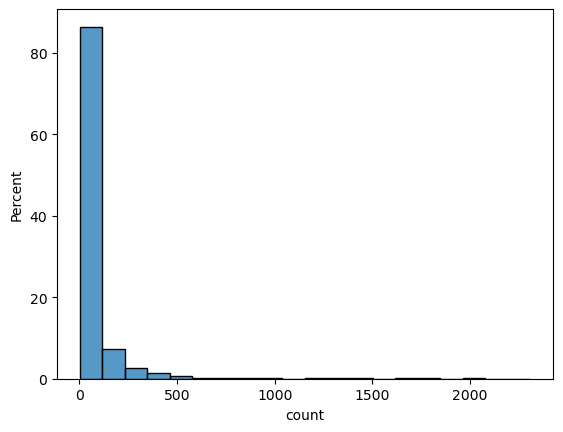

In [10]:
sns.histplot(data=tract_summary, x="count", stat="percent", bins=20)

# Block groups

In [11]:
GDF_BG = gpd.read_file(BG_GIS_FP)

In [12]:
gdf_rate_table_bg = gdf_rate_table.sjoin(GDF_BG, how="inner", predicate="intersects")

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [13]:
bg_summary = generate_report(gdf_rate_table_bg, "block group")
geographies_lost(GDF_TRACTS, gdf_rate_table_tracts, "block_group")
population_lost(GDF_BG, gdf_rate_table_bg, "tot_pop")
bg_summary

There are 68644 block groups.

49.5% of block groups contain a single gridded unit.

The range of units within block group is 1.0 to 225.0.

On average, there is 3 points within a block group.

The median block group has 2 gridded units in it.

The largest location rate range within a single block group is 5353.939999999999 among 4.0 units in 261639857001001.

The largest location rate variance within a single block group is 6614724.0 among 4.0 units in 261639857001001.

4.3999999999999995% of block_groups do not match to any rate point
69.0 percent of the state population did not match to a territory


,count,mean,std,min,25%,50%,75%,max,var,range
geo_id,,,,,,,,,,
260010001001000,10.0,6431.0170,32.953856,6400.83,6400.8300,6429.950,6442.83,6493.47,1086.0,92.64
260010001001010,4.0,6461.1525,16.706512,6446.50,6446.7775,6461.195,6475.57,6475.72,279.0,29.22
260010001001011,1.0,6463.3300,NaN,6463.33,6463.3300,6463.330,6463.33,6463.33,NaN,0.00
260010001001019,1.0,6446.5000,NaN,6446.50,6446.5000,6446.500,6446.50,6446.50,NaN,0.00
260010001001023,1.0,6402.8700,NaN,6402.87,6402.8700,6402.870,6402.87,6402.87,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...
261653808003008,1.0,5845.6500,NaN,5845.65,5845.6500,5845.650,5845.65,5845.65,NaN,0.00
261653808003018,1.0,5825.1800,NaN,5825.18,5825.1800,5825.180,5825.18,5825.18,NaN,0.00
261653808003019,1.0,5826.7200,NaN,5826.72,5826.7200,5826.720,5826.72,5826.72,NaN,0.00


<Axes: xlabel='count', ylabel='Percent'>

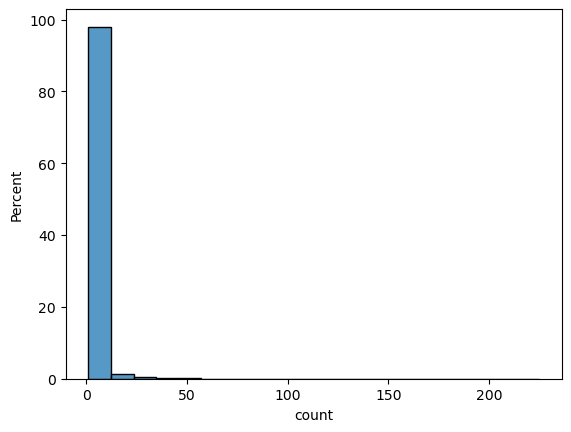

In [14]:
sns.histplot(data=bg_summary, x="count", stat="percent", bins=20)

In [15]:
# clear up some memory before reading in blocks
del GDF_BG

# Blocks

In [16]:
GDF_BLOCKS = gpd.read_file(BLOCK_GIS_FP)

In [17]:
gdf_rate_table_blocks = gdf_rate_table.sjoin(
    GDF_BLOCKS, how="left", predicate="intersects"
)
gdf_rate_table_blocks

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


,company,vehicle_type,geography_type,geography_factor_id,latitude,longitude,generic_location_based_premium,geometry,index_right,geo_id,...,other_tot,two_plus_tot,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct
0,State Farm,Auto,coordinate,416908441,41.69,-84.41,5916.32,POINT (-84.41000 41.69000),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,State Farm,Auto,coordinate,416908442,41.69,-84.42,5894.69,POINT (-84.42000 41.69000),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,State Farm,Auto,coordinate,416908443,41.69,-84.43,5848.10,POINT (-84.43000 41.69000),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,State Farm,Auto,coordinate,416908444,41.69,-84.44,5880.27,POINT (-84.44000 41.69000),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,State Farm,Auto,coordinate,416908445,41.69,-84.45,5880.27,POINT (-84.45000 41.69000),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176720,State Farm,Auto,coordinate,481908842,48.19,-88.42,6651.62,POINT (-88.42000 48.19000),252980.0,260839801001004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176721,State Farm,Auto,coordinate,481908843,48.19,-88.43,6088.59,POINT (-88.43000 48.19000),252980.0,260839801001004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176722,State Farm,Auto,coordinate,481908844,48.19,-88.44,6088.59,POINT (-88.44000 48.19000),252980.0,260839801001004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176723,State Farm,Auto,coordinate,482008833,48.20,-88.33,6088.59,POINT (-88.33000 48.20000),252980.0,260839801001004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
gdf_rate_table_blocks = gdf_rate_table_blocks[gdf_rate_table_blocks["tot_pop"] > 0]

In [19]:
block_summary = generate_report(gdf_rate_table_blocks, "block", groupby="geo_id")
geographies_lost(GDF_BLOCKS, gdf_rate_table_blocks, "block")
population_lost(GDF_BLOCKS, gdf_rate_table_blocks, "tot_pop")

There are 56594 blocks.

49.0% of blocks contain a single gridded unit.

The range of units within block is 1.0 to 185.0.

On average, there is 2 points within a block.

The median block has 2 gridded units in it.

The largest location rate range within a single block is 3012.4800000000005 among 3.0 units in 261450117022026.

The largest location rate variance within a single block is 3695638.0 among 2.0 units in 260490105031007.

77.8% of blocks do not match to any rate point
69.0 percent of the state population did not match to a territory


<Axes: xlabel='count', ylabel='Percent'>

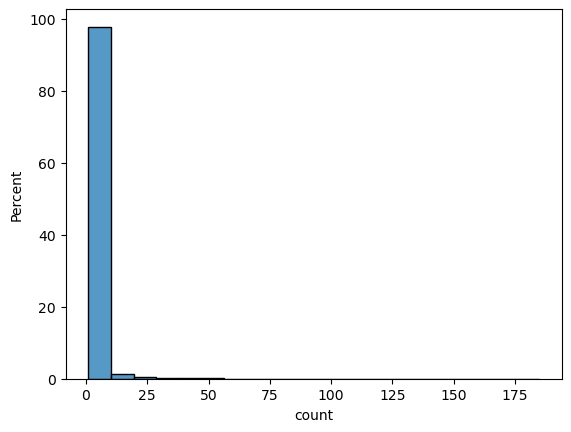

In [20]:
sns.histplot(data=block_summary, x="count", stat="percent", bins=20)

# ZCTA

In [21]:
GDF_ZCTA = gpd.read_file(ZCTA_GIS_FP)
GDF_ZCTA = GDF_ZCTA[GDF_ZCTA["total_pop"] > 0]

In [22]:
gdf_rate_table_zcta = gdf_rate_table.sjoin(
    GDF_ZCTA, how="inner", predicate="intersects"
)

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [23]:
zcta_summary = generate_report(gdf_rate_table_zcta, "zcta")
geographies_lost(GDF_ZCTA, gdf_rate_table_zcta, "ZCTA")
population_lost(GDF_ZCTA, gdf_rate_table_zcta)
zcta_summary

There are 974 zctas.

2.4% of zctas contain a single gridded unit.

The range of units within zcta is 1.0 to 2242.0.

On average, there is 176 points within a zcta.

The median zcta has 114 gridded units in it.

The largest location rate range within a single zcta is 15293.900000000001 among 24.0 units in 860Z200US48203.

The largest location rate variance within a single zcta is 18088854.0 among 21.0 units in 860Z200US48234.

1.3% of ZCTAs do not match to any rate point
0.0 percent of the state population did not match to a territory


,count,mean,std,min,25%,50%,75%,max,var,range
geo_id,,,,,,,,,,
860Z200US48001,60.0,7620.419833,210.853401,7178.94,7501.6950,7625.860,7740.0550,8223.86,44459.0,1044.92
860Z200US48002,108.0,6344.369537,103.123073,6097.88,6278.4525,6344.675,6422.2875,6548.42,10634.0,450.54
860Z200US48003,98.0,6328.673265,199.432048,6013.28,6185.8575,6266.875,6477.8900,6852.88,39773.0,839.60
860Z200US48005,108.0,7163.690463,184.177557,6286.50,7090.1050,7186.435,7272.9800,7529.51,33921.0,1243.01
860Z200US48006,211.0,6502.371991,165.630006,6118.86,6400.5150,6503.880,6619.1100,6991.54,27433.0,872.68
...,...,...,...,...,...,...,...,...,...,...
860Z200US49968,800.0,6195.506600,62.369405,6038.67,6150.3400,6198.295,6240.3550,6359.46,3890.0,320.79
860Z200US49969,845.0,6075.999065,158.201838,5765.57,5926.2200,6083.680,6195.2500,6536.92,25028.0,771.35
860Z200US49970,279.0,5935.868100,74.444561,5781.55,5880.9650,5923.730,5995.5650,6088.84,5542.0,307.29


# Appendix